In [1]:
import torch
import pytorch_lightning as pl

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import bliss

from bliss.datasets.simulated import SimulatedDataset
import bliss.models.encoder as encoder
from bliss.models.decoder import ImageDecoder
from bliss import sleep
from bliss import plotting

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
# torch.manual_seed(2342)
# np.random.seed(354)

# Model parameters

In [4]:
# create training dataset
n_bands = 2
slen = 8

tile_slen = 2

In [5]:
# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 686.0

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)

In [7]:
# None referes to no galaxies
prob_galaxy = 0.
dec_args = (None, psf_params, background)

decoder_kwargs = dict(n_bands=n_bands,
                        slen=slen,
                        tile_slen=tile_slen,
                        prob_galaxy=prob_galaxy,
                        max_sources_per_tile=4,
                        mean_sources_per_tile=0.8,
                        min_sources_per_tile=0,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=True)

# Define dataset

In [8]:
n_batches = 20
batchsize = 2048
dataset = SimulatedDataset(n_batches, batchsize, dec_args, decoder_kwargs)

### a few example images

In [9]:
data_sampled = dataset.get_batch()
images = data_sampled['images']

n_sources_full, locs_full = \
    encoder._get_full_params_from_sampled_params(
                                                    slen,
                                                    tile_slen,
                                                    data_sampled['n_sources'],
                                                    data_sampled['locs'])

In [10]:
%matplotlib inline  

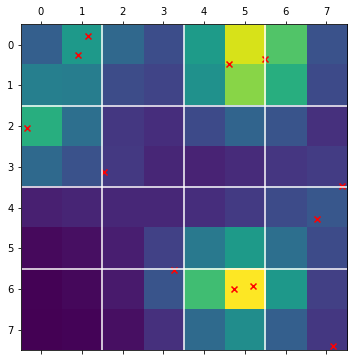

In [11]:
f, axarr = plt.subplots(1, 1, figsize=(6, 6))

batch = int(np.random.choice(batchsize))
band = 0

# plot image
axarr.matshow(images[batch, band].cpu().detach())

# plot locations 
n = int(n_sources_full[batch])
axarr.scatter(locs_full[batch, 0:n, 1].cpu() * slen - 0.5, 
              locs_full[batch, 0:n, 0].cpu() * slen - 0.5, 
              color = 'red', marker = 'x')

for i in range(int(slen / tile_slen)): 
    axarr.axvline(tile_slen * i - 0.5, color = 'white')
    axarr.axhline(tile_slen * i - 0.5, color = 'white')
    

# Define encoder 

In [12]:
edge_padding = 3
ptile_slen = tile_slen + 2 * edge_padding
encoder_kwargs = dict(slen=slen,
                        ptile_slen=ptile_slen,
                        tile_slen=tile_slen,
                        n_bands=n_bands,
                        max_detections=dataset.image_decoder.max_sources_per_tile,
                        n_galaxy_params=8,
                        enc_conv_c=20,
                        enc_kern=3,
                        enc_hidden=256,
                        momentum=0.5)

In [13]:
sleep_net = sleep.SleepPhase(dataset, encoder_kwargs)
sleep_net.to(device);

In [14]:
sleep_net.get_loss(dataset.get_batch())

(tensor(87.2560, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor([1.4897, 2.1213, 1.3158,  ..., 1.8715, 1.5017, 1.1019], device='cuda:0',
        grad_fn=<NegBackward>),
 tensor([-0.0000, 3.3363, -0.0000,  ..., -0.0000, -0.0000, 5.5327],
        device='cuda:0', grad_fn=<MinBackward0>),
 tensor([-0., -0., -0.,  ..., -0., -0., -0.], device='cuda:0',
        grad_fn=<NegBackward>),
 tensor([ -0.0000, 181.5317,  -0.0000,  ...,  -0.0000,  -0.0000, 547.8616],
        device='cuda:0', grad_fn=<NegBackward>),
 tensor([-0.0000, 1.5121, -0.0000,  ..., -0.0000, -0.0000, 1.9304],
        device='cuda:0', grad_fn=<NegBackward>))

# Train!

In [15]:
n_epochs = 40

In [16]:
sleep_trainer = pl.Trainer(
            gpus = 1,
            min_epochs=n_epochs,
            max_epochs=n_epochs,
            reload_dataloaders_every_epoch=True,
            logger=False,
            checkpoint_callback=False,
        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [17]:
sleep_trainer.fit(sleep_net)


  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 537 K 
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1: : 20it [00:04,  4.98it/s, loss=31.163]
Validating: 0it [00:00, ?it/s]
Epoch 1: : 23it [00:04,  5.53it/s, loss=31.163]
Epoch 1: : 26it [00:04,  6.06it/s, loss=31.163]
Epoch 1: : 29it [00:04,  6.56it/s, loss=31.163]
Epoch 1: : 32it [00:04,  7.02it/s, loss=31.163]
Epoch 1: : 35it [00:04,  7.46it/s, loss=31.163]
Epoch 1: : 40it [00:04,  8.12it/s, loss=31.163]
Epoch 2: : 20it [00:04,  4.87it/s, loss=8.330]
Epoch 2: : 21it [00:04,  5.06it/s, loss=8.330]
Epoch 2: : 24it [00:04,  5.60it/s, loss=8.330]
Epoch 2: : 27it [00:04,  6.11it/s, loss=8.330]
Epoch 2: : 30it [00:04,  6.59it/s, loss=8.330]
Epoch 2: : 33it [00:04,  7.05it/s, loss=8.330]
Epoch 2: : 36it [00:04,  7.47it/s, loss=8.330]
Epoch 2: : 40it [00:04,  8.00it/s, loss=8.330]
Epoch 3: : 20it [00:03,  5.04it/s, loss=6.905]
Epoch 3: : 21it [00:04,  5.23it/s, loss=6.905]
Epoch 3: : 24it [00:04,  5.78it/s, loss=6.905]
Epoch 3: : 27it [00:04,  6.30it/s, loss=6.905]
Epoch 3: : 30it [00:04,  6.80it/s, loss=6.905]
Epoch 3: : 33it [00:04

1

# Check on test data

In [23]:
test_data = dataset.get_batch()

Copy-pasted / adapted from `make_validation_plots`

In [24]:
outputs = [dict(log = test_data)]
n_samples = min(5, len(outputs[-1]["log"]["n_sources"]))
assert n_samples > 1

#################
# TRUE PARAMETERS
#################
# these are per tile
true_n_sources_on_tiles = outputs[-1]["log"]["n_sources"][:n_samples]
true_locs_on_tiles = outputs[-1]["log"]["locs"][:n_samples]

# convert to full image 
true_n_sources, true_locs = \
    encoder._get_full_params_from_sampled_params(
                                                    sleep_net.image_encoder.slen,
                                                    sleep_net.image_encoder.tile_slen,
                                                    true_n_sources_on_tiles,
                                                    true_locs_on_tiles)

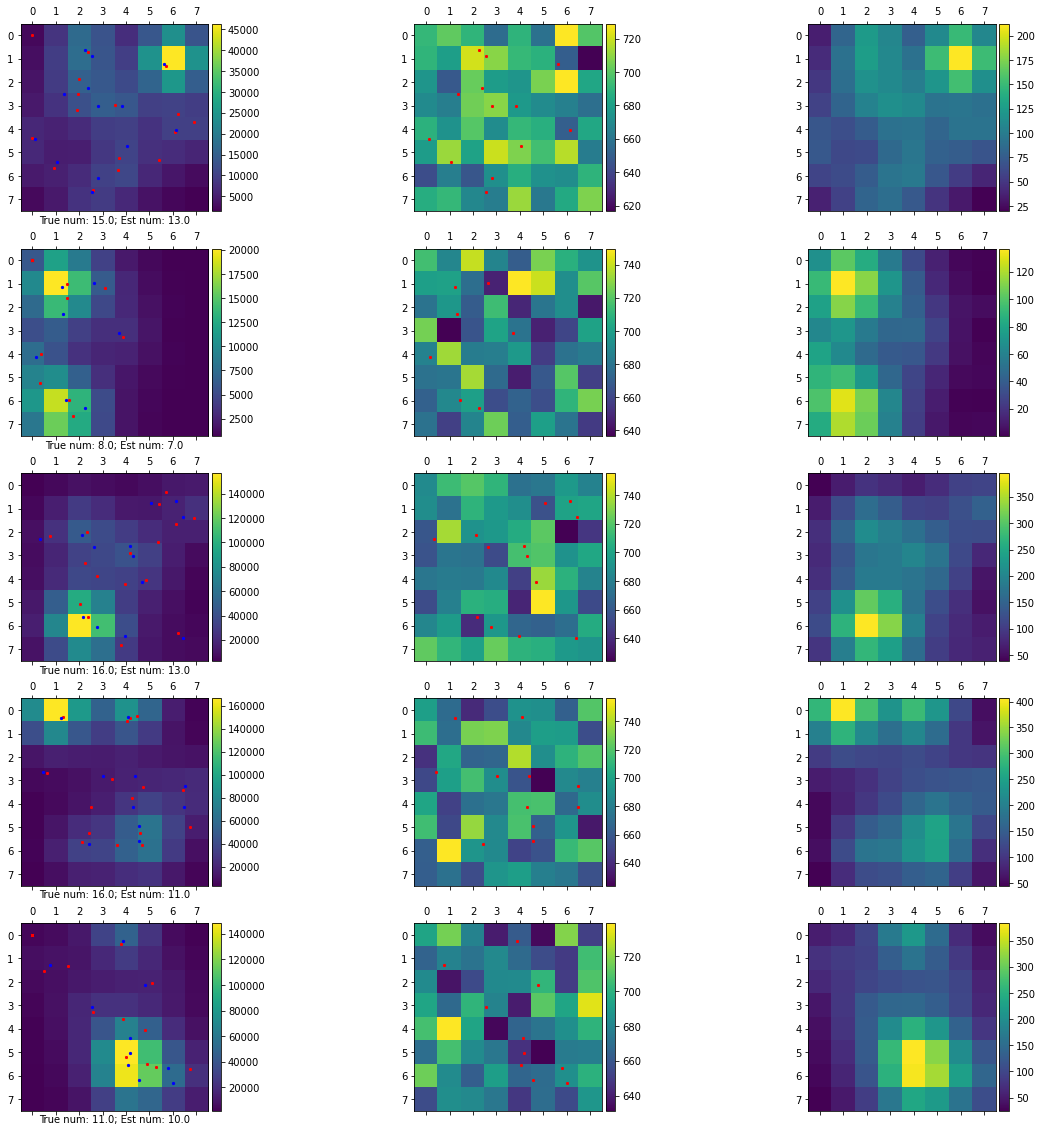

In [25]:
images = outputs[-1]["log"]["images"][:n_samples]
fig, axes = plt.subplots(
    nrows=n_samples,
    ncols=3,
    figsize=(
        20,
        20,
    ),
)

for i in range(n_samples):
    true_ax = axes[i, 0]
    recon_ax = axes[i, 1]
    res_ax = axes[i, 2]

    image = images[i]
    true_loc = true_locs[i]
    true_n_source = true_n_sources[i]

    with torch.no_grad():
        # get the estimated params: these are per tile
        sleep_net.image_encoder.eval()
        (
            tile_n_sources,
            tile_locs,
            tile_galaxy_params,
            tile_log_fluxes,
            tile_galaxy_bool,
        ) = sleep_net.image_encoder.map_estimate(image.unsqueeze(0))

    # convert tile estimates to full parameterization
    # for plotting
    n_sources, locs, galaxy_params, log_fluxes, galaxy_bool = \
        sleep_net.image_encoder.get_full_params_from_sampled_params(tile_n_sources,
        tile_locs,
        tile_galaxy_params,
        tile_log_fluxes,
        tile_galaxy_bool)

    # draw true image
    assert len(image.shape) == 3
    image = image[0].cpu().numpy()  # first band.
    loc = locs[0].cpu().numpy()
    true_loc = true_loc.cpu().numpy()
    plotting.plot_image(fig, true_ax, image, true_loc, loc)
    true_ax.set_xlabel(
        f"True num: {true_n_source.item()}; Est num: {n_sources.item()}"
    )

    # only prediction/residual if at least 1 source.
    max_sources = n_sources.max().int().item()
    if max_sources > 0:
        assert max_sources == locs.shape[1]

        # draw reconstruction image.
        recon_image = sleep_net.dataset.image_decoder.render_images(
                tile_n_sources,
                tile_locs,
                tile_galaxy_bool,
                tile_galaxy_params,
                tile_log_fluxes
            )
        assert len(locs.shape) == 3 and locs.size(0) == 1
        recon_image = recon_image[0, 0].cpu().numpy()
        res_image = (image - recon_image) / np.sqrt(image)

        # plot
        plotting.plot_image(fig, recon_ax, recon_image, loc)
        plotting.plot_image(fig, res_ax, res_image)

    else:
        slen = image.shape[0]
        plotting.plot_image(fig, recon_ax, np.zeros((slen, slen)))
        plotting.plot_image(fig, res_ax, np.zeros((slen, slen)))

# plt.subplots_adjust(hspace=0.25, wspace=-0.2)
# if self.logger:
#     self.logger.experiment.add_figure(f"Val Images {self.current_epoch}", fig)


In [26]:
obs_img = test_data['images'][0:1]

In [27]:
obs_img

tensor([[[[ 2506.8965,  8233.1182, 17007.0684, 12924.8203,  7381.3066,
           13627.7266, 23769.6230, 13215.8740],
          [ 3154.3569,  9714.9775, 17546.5645, 13378.7383,  9719.1387,
           24446.5645, 46392.1641, 24344.0117],
          [ 3811.9431,  9287.2881, 15184.7520, 13765.2617, 11561.6104,
           15904.4141, 25162.4238, 14810.7168],
          [ 4602.9561,  8038.9868, 12366.1104, 14867.5273, 13699.1846,
            9979.1758, 10329.3916,  9545.1494],
          [ 6387.9600,  5689.5527,  7085.4331,  9667.4941, 10056.1699,
            8119.6436,  9904.7812, 10010.1367],
          [ 6642.0049,  5107.0303,  5238.8179,  8667.9131, 10486.9766,
            7646.7222,  7188.8545,  6193.7329],
          [ 4698.7754,  5334.6538,  6942.6416, 10148.0908, 10950.3779,
            6525.2007,  4202.4150,  2772.2620],
          [ 2574.4685,  4506.9058,  8042.8701,  9294.7178,  6732.1074,
            3599.4751,  2253.0127,  1470.6429]],

         [[ 3795.5518, 11542.0615, 20607.7051,

In [53]:
with torch.no_grad():
    sleep_net.eval()
    (
        n_stars_sampled,
        locs_sampled,
        galaxy_params_sampled,
        log_fluxes_sampled,
        galaxy_bool_sampled,
    ) = sleep_net.image_encoder.sample_encoder(obs_img, 10)


In [57]:
stars = dataset.image_decoder.render_images(
            n_stars_sampled,
            locs_sampled,
            galaxy_bool_sampled,
            galaxy_params_sampled,
            log_fluxes_sampled.exp())

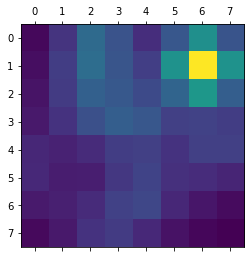

In [58]:
plt.matshow(obs_img[0, 0, :, :].cpu().detach())

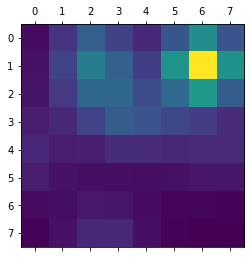

In [59]:
plt.matshow(stars[0, 0, :, :].cpu().detach())